In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [55]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np


class RescaleNorm(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z, power=0):
        ctx.save_for_backward(z)
        ctx.power = power
        return z

    @staticmethod
    def backward(ctx, grad_output):
        z = ctx.saved_tensors[0]
        power = ctx.power
        norm = torch.linalg.vector_norm(z, dim=-1, keepdim=True)

        return grad_output * norm**power, None

def repulsive_loss(z_1, z_2, t=0.5):
    sims = z_1 @ z_2.t() / t

    # Set the diagonals to be large negative values, which become essentially zeros after softmax.
    sims[torch.arange(z_1.size()[0]), torch.arange(z_1.size()[0])] = float("-inf") #-1e5 #  

    exp = torch.exp(sims)
    sum_exp = torch.sum(exp, dim=-1)
    log_sum_exp = torch.log(sum_exp)

    return torch.mean(log_sum_exp)

def attractive_loss(z_1, z_2, t=0.5):
    sim = z_1 * z_2
    sim = torch.sum(sim, dim=-1)
    total_loss = torch.mean(sim) / t

    return -total_loss

def nt_xent(
        z_1,
        z_2,
        t=0.5,
        power=0,
        norm_function=F.normalize,
        repulsion_factor = 1,
        attraction_factor = 1
        ):
    z_1 = RescaleNorm.apply(z_1, power)
    z_2 = RescaleNorm.apply(z_2, power)

    z_1 = norm_function(z_1, dim=1)
    z_2 = norm_function(z_2, dim=1)
    attr_loss = attractive_loss(z_1, z_2, t=t)
    rep_loss = repulsive_loss(z_1, z_2, t=t)
    return attraction_factor * attr_loss + repulsion_factor * rep_loss

def infoNCE(
        features,
        temperature=0.5, 
        norm_function=F.normalize,
        power=0,
        reduction = "mean"
        ):
    batch_size = features.size(0) // 2

    features = RescaleNorm.apply(features, power)
    x = norm_function(features)
    cos_xx = x @ x.T / temperature

    cos_xx.fill_diagonal_(float("-inf"))
        
    targets = torch.arange(cos_xx.size(0), dtype=int, device=cos_xx.device)
    targets[:batch_size] += batch_size
    targets[batch_size:] -= batch_size

    return F.cross_entropy(cos_xx, targets, reduction=reduction)

def embed_dataset(model, dataset):
        model.eval()
        with torch.no_grad():
            X, y, Z = [], [], []

            for batch in DataLoader(dataset, batch_size=1024):
                images, labels = batch

                h, z, c = model(images.to(model.device))

                X.append(h.cpu().numpy())
                Z.append(z.cpu().numpy())
                y.append(labels)

            X = np.vstack(X)
            y = np.hstack(y)
            Z = np.vstack(Z)

            return X, y, Z
        model.train()

In [89]:
from lightning_simclr import SimCLR
ckpt = "logs/No_schedule-_No_decay-1000/l2/no_decay-no_momentum/checkpoint/epoch=99.ckpt"
mod = SimCLR.load_from_checkpoint(ckpt, strict=False)

/gpfs01/berens/user/jdoehl/GitHub/sssl/.venv/lib/python3.12/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['model.certainty_head.0.weight', 'model.certainty_head.0.bias', 'model.certainty_head.2.weight', 'model.certainty_head.2.bias']


In [82]:
from lightning_simclr import SimCLR

mod = SimCLR("cifar10", seed=0).to("cuda")

In [90]:
from data_utils import get_augmented_dataloader
data_loader = get_augmented_dataloader(mod.dataset_name)
batch = next(iter(data_loader))
batch = [batch_item.to("cuda") for batch_item in batch]

old_state = {k: v.clone() for k, v in mod.state_dict().items()}

  0%|          | 0/1 [00:00<?, ?it/s]

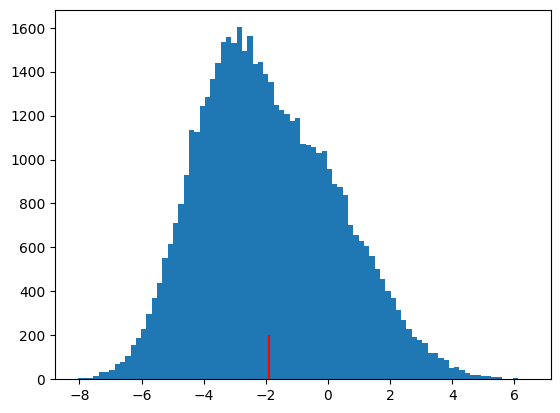

In [94]:
from torch.optim import SGD
from tqdm.notebook import trange

norm_changes = torch.empty((2,mod.batch_size))


for k in trange(1):
    mod.load_state_dict(old_state)
    
    X, y, Z = embed_dataset(mod, mod.knn_train_dataset)
    all_embed_norms_before = np.linalg.norm(X, axis=1)
    optimizer = SGD(
            mod.parameters(),
            lr=(mod.base_lr * mod.batch_size/ 256) * 0.1,
            momentum=mod.momentum,
            weight_decay=mod.weight_decay,
            nesterov=mod.nestrov,
        )
    optimizer.zero_grad()

    idx, view1, view2, labels = batch
    _, z1, c1 = mod.model(view1)
    _, z2, c2 = mod.model(view2)


    idxs = list(range(1000))

    #Stop gradients for all but one sample in z1
    z1_mod = z1.detach().clone()
    z1_mod[idxs] = z1[idxs]  # keep gradient for sample k
    z1 = z1_mod
    # z1 = z1.detach()

    z2_mod = z2.detach().clone()
    z2_mod[idxs] = z2[idxs]  # keep gradient for sample k
    z2 = z2_mod
    # z2 = z2.detach()

    loss = nt_xent(z1, z2, attraction_factor=1, repulsion_factor=0.5)

    loss.backward()
    optimizer.step()


    with torch.no_grad():
        _, z1_new, c1_new = mod.model(view1)
        _, z2_new, c2_new= mod.model(view2)

    norm_diff1 = z1_new.norm(dim=1) - z1.norm(dim=1)
    norm_diff2 = z2_new.norm(dim=1) - z2.norm(dim=1)
    # print(norm_diff1[k].item(), norm_diff2[k].item())
    # print(norm_diff1[k+1].item(), norm_diff2[k+1].item())
    # print()
    norm_changes[0,k], norm_changes[1,k] = norm_diff1[k], norm_diff2[k]


X, y, Z = embed_dataset(mod, mod.knn_train_dataset)
all_embed_norms_after = np.linalg.norm(X, axis=1)
import matplotlib.pyplot as plt
norm_diff = (all_embed_norms_after - all_embed_norms_before)
plt.hist(norm_diff, bins="auto")
plt.vlines(norm_diff.mean(), 0, 200, colors="red")
plt.show()

In [71]:
optimizer.param_groups[0]["lr"]

0.24

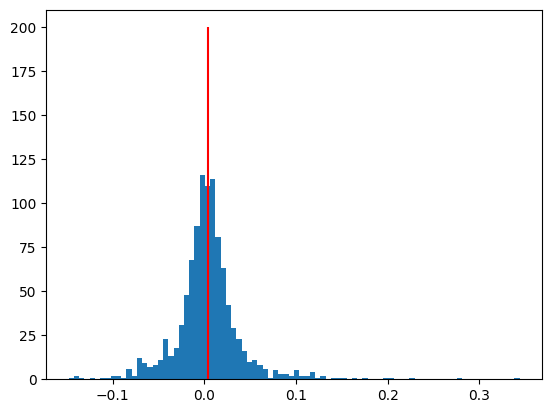

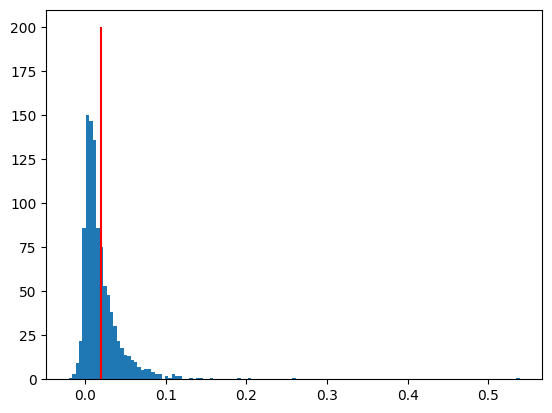

In [ ]:
import matplotlib.pyplot as plt
norm_diff = norm_changes[0].detach().cpu()
norm1 = norm_changes[1].detach().cpu()
plt.hist(norm_diff, bins="auto")
plt.vlines(norm_diff.mean(), 0, 200, colors="red")
plt.show()
plt.hist(norm1, bins="auto")
plt.vlines(norm1.mean(), 0, 200, colors="red")
plt.show()

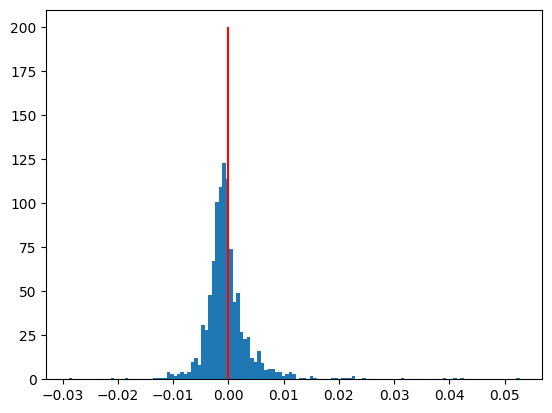

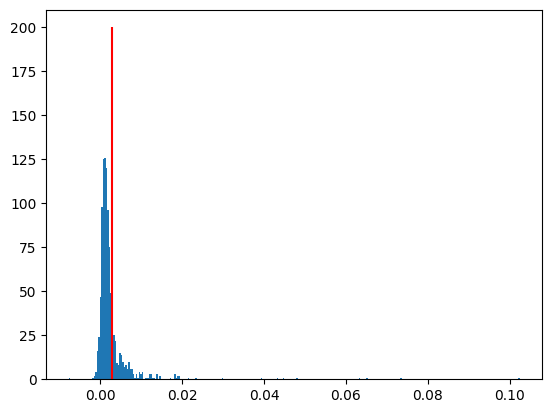

In [ ]:
import matplotlib.pyplot as plt
# norm_changes_init = norm_changes
norm_diff = norm_changes_init[0].detach().cpu()
norm1 = norm_changes_init[1].detach().cpu()
plt.hist(norm_diff, bins="auto")
plt.vlines(norm_diff.mean(), 0, 200, colors="red")
plt.show()
plt.hist(norm1, bins="auto")
plt.vlines(norm1.mean(), 0, 200, colors="red")
plt.show()

In [18]:
from torch.optim import SGD

mod.load_state_dict(old_state)
optimizer = SGD(
        mod.parameters(),
        lr=mod.base_lr * mod.batch_size/ 256,
        momentum=mod.momentum,
        weight_decay=mod.weight_decay,
        nesterov=mod.nestrov,
    )
optimizer.zero_grad()

idx, view1, view2, labels = batch
_, z1, c1 = mod.model(view1)
_, z2, c2 = mod.model(view2)

loss = infoNCE(torch.cat((z1, z2)), reduction="mean")

loss.backward()
optimizer.step()


with torch.no_grad():
    _, z1_new, c1_new = mod.model(view1)
    _, z2_new, c2_new= mod.model(view2)
